# Data generation for ART input

Tested using biodesign_3.7 kernel on the jprime.lbl.gov server. It uses the cplex library for running the MOMA optimization

# Content for the library

## Setup

In [1]:
import collections as col
import os
import random
import re
import sys
import warnings
from shutil import copyfile
from enum import Enum
from typing import NewType, Dict, List, Any, OrderedDict, Counter

import cobra
import numpy as np
import pandas as pd
from cobra.exceptions import OptimizationError, Infeasible
from matplotlib import pyplot as plt

## Global parameters

In [2]:
# Type annotations
Filename = NewType('Filename', str)

# Enumerations
class Omics(Enum):
    """Enumeration with supported omics data types."""
    PROTEOMICS = 0
    TRANSCRIPTOMICS = 1
    METABOLOMICS = 2

    def __str__(self):
        return f'{str(self.name).lower()}'


# Constants
UNIPROT_URL = '''https://www.uniprot.org/uploadlists/'''
CTS_URL = '''https://cts.fiehnlab.ucdavis.edu/rest/convert/'''
# HOST NAME
HOST_NAME: str = 'ropacus' 
# TODO: Move some constants to variables by program arguments
DATA_FILE_PATH: Filename = Filename('data')
# Output file path
OUTPUT_FILE_PATH: Filename = Filename('data/output')
# INCHIKEY_TO_CID_MAP_FILE_PATH: mapping file path to map inchikey to cids
#INCHIKEY_TO_CID_MAP_FILE_PATH: Filename = Filename('mapping') 
INCHIKEY_TO_CID_MAP_FILE_PATH: Filename = Filename('/scratch/hgmartin/libraries/OMG/mapping')
# MODEL_FILENAME: Filename = Filename('iECIAI39_1322.xml')  # E. coli
MODEL_FILENAME: Filename = Filename('reannotated_base_v3.sbml')  # R. opacus
# TODO: rename traininig file name to design file names and paths
# Training file name
TRAINING_FILE_NAME: Filename = Filename('')
TRAINING_FILE_PATH: Filename = Filename('')
# Start time and stop time
TIMESTART: float = 0.0
TIMESTOP: float = 8.0
NUMPOINTS: int = 9
# number of reactions and instances
NUM_REACTIONS: int = None
NUM_INSTANCES: int = None

# NOTE: user input to the program
BIOMASS_REACTION_ID: str = 'BIOMASS_Ec_iJO1366_core_53p95M'  # E. coli
REACTION_ID: str = 'biomass_target'  # R. opacus
# REACTION_ID: str = 'SRC_C00185_e'  # R. opacus
GENE_IDS_DBS: List[str] = ['kegg.genes']  # R. opacus
# GENE_IDS_DBS: List[str] = ['uniprot', 'goa', 'ncbigi']  # E. coli
UNITS: Dict[Omics, str] = {
    Omics.PROTEOMICS: 'proteins/cell',
    Omics.TRANSCRIPTOMICS: "FPKM",
    Omics.METABOLOMICS: "mg/L"
}
# Fix the flux value to a particular value
LOWER_BOUND: int = -15
UPPER_BOUND: int = -15

## FUNCTION A
### [Fluxes,extMetabolitesCon, OD]   = getFluxTimeSeries(GSM, InitialExtMetabolitesCon)

In [3]:
def get_flux_time_series(model, ext_metabolites, grid):
    '''
    Generate fluxes and OD
    '''
    
    ## First unpack the time steps for the grid provided
    tspan, delt = grid

    ## Create a panda series containing the cell concentation for each time point
    cell = pd.Series(index=tspan)
    cell0 = user_params['initial_OD'] # in gDW/L
    cell[t0] = cell0

    ## Create a dataframe that constains external metabolite names and their concentrations
    # First organize external metabolites and their initial concentrations
    met_names = []
    initial_concentrations = []
    for met, init_conc in ext_metabolites.items():
        met_names.append(met)
        initial_concentrations.append(init_conc)
    # Create dataframe containing external metabolites
    Emets = pd.DataFrame(index=tspan, columns=met_names)
    # Add initial concentrations for external metabolites
    Emets.loc[t0] = initial_concentrations    
    # Create Dictionary mapping exchange reactions to the corresponding external metabolite 
    Erxn2Emet = {r.id: r.reactants[0].id for r in model.exchanges if r.reactants[0].id in met_names}
        
    
    ## Create storage for timeseries of models and solutions
    # Model time series
    model_TS = pd.Series(index=tspan)
    # Solution time series
    solution_TS = pd.Series(index=tspan)

    
    ## Main for loop solving the model for each time step and adding the corresponding OD and external metabolites created
    volume = 1.0  # volume set arbitrarily to one because the system is extensive
    for t in tspan:
        # Adding constraints for each time point without permanent changes to the model
        with model:
            for rxn, met in Erxn2Emet.items():
                # For each exchange reaction set lower bound such that the corresponding 
                # external metabolite concentration does not become negative 
                model.reactions.get_by_id(rxn).lower_bound = max(model.reactions.get_by_id(rxn).lower_bound, 
                                                                -Emets.loc[t,met]*volume/cell[t]/delt)
            
            # Calculate fluxes 
            solution_t = model.optimize()
            
            # Store the solution and model for each timepoint for future use (e.g. MOMA)
            solution_TS[t] = solution_t
            model_TS[t] = model.copy()
                        
            # Calculate OD and external metabolite concentrations for next time point t+delta
            cell[t+delt], Emets.loc[t+delt] = advance_OD_Emets(Erxn2Emet, cell[t], Emets.loc[t], delt, solution_t, BIOMASS_REACTION_ID)
            print(t, solution_t.status, solution_t[BIOMASS_REACTION_ID])     # Minimum output for testing
            
    return solution_TS, model_TS, cell, Emets, Erxn2Emet

In [4]:
def advance_OD_Emets(Erxn2Emet, old_cell, old_Emets, delt, solution, BIOMASS_REACTION_ID):
    # Output is same as input if nothing happens in the if clause
    new_cell  = old_cell
    new_Emets = old_Emets
    
    # Obtain the value of mu (growth rate)
    mu = solution[BIOMASS_REACTION_ID]
    
    # Calculate OD and external metabolite concentrations for next step
    if solution.status == 'optimal' and mu > 1e-6:  # Update only if solution is optimal and mu is not zero, otherwise do not update
        # Calculating next time point's OD
        new_cell = old_cell *np.exp(mu*delt) 
        # Calculating external external metabolite concentrations for next time point
        for rxn, met in Erxn2Emet.items():
            new_Emets[met] = max(old_Emets.loc[met]-solution[rxn]/mu*old_cell*(1-np.exp(mu*delt)),0.0)  
    
    return new_cell, new_Emets

## FUNCTION B
### BEFluxes = getBEFluxes(Fluxes, Change, GSM)

In [5]:
def getBEFluxes(model_TS, design, solution_TS, grid):
    ## Unpacking time points grid
    tspan, delt = grid

    ## Unpack information for desired flux changes
    # Get names for reaction targets
    reaction_names =list(design.index[1:])
    # Find number of target reactions and number of designs (or strains changed)
    #n_reactions = design.shape[1] - 1
    #n_instances = design.shape[0] - 1
        
    ## Time series containing the flux solution obtained through MOMA
    solutionsMOMA_TS = pd.Series(index=tspan)

    ## Main loop: for each strain and at each time point, find new flux profile through MOMA    
    volume = 1.0
    #for i in range(0,n_instances):
    for t in tspan:
        model = model_TS[t]
        with model:
            # Adding the fluxed modifications for chosen reactions
            for reaction in reaction_names:
                reaction_constraint = model.problem.Constraint(model.reactions.get_by_id(reaction).flux_expression, 
                                            lb = model.reactions.get_by_id(reaction).lower_bound*design[reaction],
                                            ub = model.reactions.get_by_id(reaction).upper_bound*design[reaction])
                model.add_cons_vars(reaction_constraint)

            # Reference solution calculated for each time point in above cell for wild type
            sol1 = solution_TS[t]

            # Moma solution for each time point
            sol2 = cobra.flux_analysis.moma(model, solution=sol1, linear=True) # we changed the linear=True for faster calculation
                
            # saving the moma solutions across timepoints
            solutionsMOMA_TS[t] = sol2
                
    return solutionsMOMA_TS
                
                

## FUNCTION C
### (Trans,Prot,Met) = getMultiomics(Fluxes, GSM)

In [6]:
def read_pubchem_id_file():
    inchikey_to_cid = {}
    filename = f'{INCHIKEY_TO_CID_MAP_FILE_PATH}/inchikey_to_cid.txt'
    with open(filename, 'r') as fh:
            try:
                line = fh.readline()
                while line:
                    # checking to ignore inchikey records with no cid mappings
                    if (len(line.split()) > 1):
                        inchikey_to_cid[line.split()[0]] = 'CID:'+line.split()[1]
                    else:
                        inchikey_to_cid[line.strip()] = None

                    line = fh.readline()
            # NOTE: propagated exception, raise
            except Exception as ex:
                print("Error in reading file!")
                print(ex)

    return inchikey_to_cid


def get_proteomics_transcriptomics_data(model, solution):
    """

    :param model:
    :param solution:
    :param condition:
    :return:
    """

    # pre-determined linear constant (NOTE: Allow user to set this via parameter)
    # DISCUSS!!
    k = 0.8
    q = 0.06

    proteomics = {}
    transcriptomics = {}

    rxnIDs = solution.fluxes.keys()
    for rxnId in rxnIDs:
        reaction = model.reactions.get_by_id(rxnId)
        for gene in list(reaction.genes):

            # this will ignore all the reactions that does not have the gene.annotation property
            # DISCUSS!!
            if gene.annotation:
                if 'uniprot' not in gene.annotation:
                    if 'goa' in gene.annotation:
                        protein_id = gene.annotation['goa']
                    else:
                        break
                else:
                    protein_id = gene.annotation['uniprot'][0]
                
                # add random noise wjhich is 5 percent of the signal
                noiseSigma = 0.05 * solution.fluxes[rxnId]/k;
                noise = noiseSigma*np.random.randn();
                proteomics[protein_id] = (solution.fluxes[rxnId]/k) + noise

            # create transcriptomics dict
            noiseSigma = 0.05 * proteomics[protein_id]/q;
            noise = noiseSigma*np.random.randn();
            transcriptomics[gene.id] = (proteomics[protein_id]/q) + noise

    return proteomics, transcriptomics

# NOTE: Work on this
def get_metabolomics_data(model):
    """

    :param model:
    :param condition:
    :return:
    """
    metabolomics = {}
    # get metabolites

    # read the inchikey to pubchem ids mapping file
    inchikey_to_cid = {}
    inchikey_to_cid = read_pubchem_id_file()
    
    for met in model.metabolites:
        # get associated reactions involving metabolite
        num_reactions_with_flux = 0
        for reaction in list(met.reactions):
            # get dictionary of associated metabolites and their concentrations
            # average fluxes
            
            # if there is an inchikey ID for the metabolite
            if 'inchi_key' in met.annotation:
                # if it is a list get the first element
                if type(met.annotation['inchi_key']) is list:
                    inchi_key = met.annotation['inchi_key'][0]
                else:
                    inchi_key = met.annotation['inchi_key']
                
                # if the inchikey for the metabolite is in the mapping dict
                if inchi_key in inchikey_to_cid.keys():
                    # if the CID is not in the metabolomics dict keys AND the mappned value is not None and the reactions flux is not 0
                    if (inchikey_to_cid[inchi_key] not in metabolomics.keys()) and (inchikey_to_cid[inchi_key] is not None) and reaction.flux != 0.0:
                            metabolomics[inchikey_to_cid[inchi_key]] = abs(reaction.flux)
                            num_reactions_with_flux  += 1
                    elif (inchikey_to_cid[inchi_key] is not None) and reaction.flux != 0.0:
                            metabolomics[inchikey_to_cid[inchi_key]] += abs(reaction.flux)
                            num_reactions_with_flux  += 1

        # check if inchi_key attribite present else ignore metabolite
        if 'inchi_key' in met.annotation.keys() and inchi_key in inchikey_to_cid.keys() and inchikey_to_cid[inchi_key] is not None:
            metabolomics[inchikey_to_cid[inchi_key]]/=num_reactions_with_flux

    return metabolomics

def get_multiomics(model, solution):
    """

    :param model: cobra model object
    :param solution: solution for the model optimization using cobra
    :param data_type: defines the type of -omics data to generate (all by default)
    :return:
    """

    proteomics = {}
    transcriptomics = {}
    fluxomics = {}
    metabolomics = {}

    proteomics, transcriptomics = get_proteomics_transcriptomics_data(model, solution)

    metabolomics = get_metabolomics_data(model)

    return (proteomics, transcriptomics, metabolomics)



## FUNCTION D
### ExtMetabolites =  Integrate(Fluxes)

In [7]:
def integrate_fluxes(solution_TS, model_TS, ext_metabolites, grid, BIOMASS_REACTION_ID):
    ## First unpack the time steps for the grid provided
    tspan, delt = grid

    ## Create a panda series containing the cell concentation for each time point
    cell = pd.Series(index=tspan)
    cell0 = user_params['initial_OD'] # in gDW/L
    cell[t0] = cell0
    
    ## Create a dataframe that constains external metabolite names and their concentrations (DUPLICATED CODE)
    # First organize external metabolites and their initial concentrations
    model = model_TS[0]
    met_names = []
    initial_concentrations = []
    for met, init_conc in ext_metabolites.items():
        met_names.append(met)
        initial_concentrations.append(init_conc)
    # Create dataframe containing external metabolites
    Emets = pd.DataFrame(index=tspan, columns=met_names)
    # Add initial concentrations for external metabolites
    Emets.loc[t0] = initial_concentrations    
    # Create Dictionary mapping exchange reactions to the corresponding external metabolite 
    Erxn2Emet = {r.id: r.reactants[0].id for r in model.exchanges if r.reactants[0].id in met_names}
    
    ## Main loop adding contributions for each time step
    for t in tspan:     
        # Calculate OD and external metabolite concentrations for next time point t+delta
        cell[t+delt], Emets.loc[t+delt] = advance_OD_Emets(Erxn2Emet, cell[t], Emets.loc[t], delt, solution_TS[t], BIOMASS_REACTION_ID)
    
    return cell, Emets
        

## User parameters

In [8]:
user_params = {
    'host': 'ecoli', # ecoli or ropacus
    'modelfile': 'models/iJO1366_MVA.json',
    'modelfilepath': 'sample_files',
    'timestart': 0.0,
    'timestop': 8.0,
    'numpoints': 9,
    'designfile': 'training_data_8reactions.csv',
    'designfilepath': 'data',
    'numreactions': 8,
    'numinstances': 5,
    'ext_metabolites': {
        'glc__D_e': 22.203,
        'nh4_e': 18.695,
        'pi_e': 69.454,
        'so4_e': 2.0,
        'mg2_e': 2.0,
        'k_e': 21.883,
        'na1_e': 103.7,
        'cl_e': 27.25,
        'isoprenol_e': 0.0,
        'ac_e': 0.0,
        'for_e': 0.0,
        'lac__D_e': 0.0,
        'etoh_e': 0.0
    },
    'initial_OD': 0.01
}

# comp = ['glc__D_e', 'nh4_e', 'pi_e', 'so4_e', 'mg2_e', 'k_e', 'na1_e', 'cl_e', 'EX_isoprenol_e']
# initial_concentrations = [22.203, 18.695, 69.454, 2.0, 2.0, 21.883, 103.7, 27.25] 

-----

# Content for the Jupyter Notebook

-------

In [9]:
def plot_DO_extmets(od,ext_metabolites):
    fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
    od.plot(ax=ax[0], style='s-', title='Cell', label='dcw', legend=True)
    ax[0].set_xlabel("Hour")
    ax[0].set_ylabel("Concentration (gDW/L)")
    ext_metabolites.plot(ax=ax[1], style='o-', title='External Metabolites')
    ax[1].set_xlabel("Hour")
    ax[1].set_ylabel("Concentration (mM)")

## Demonstration of library functions for obtaining multiomics data

### Getting and preparing the metabolic model

First we obtain the metabolic model:

In [10]:
file_name = user_params['modelfile']
model = cobra.io.load_json_model(file_name)

We now add minimum flux constraints for production of isopentenol and formate, and we limit oxygen intake:

In [11]:
iso = 'EX_isoprenol_e'
iso_cons = model.problem.Constraint(model.reactions.EX_isoprenol_e.flux_expression,lb = 0.20)
model.add_cons_vars(iso_cons)
for_cons = model.problem.Constraint(model.reactions.EX_for_e.flux_expression,lb = 0.10)
model.add_cons_vars(for_cons)
o2_cons = model.problem.Constraint(model.reactions.EX_o2_e.flux_expression,lb = -8.0)
model.add_cons_vars(o2_cons)

Constrain several central carbon metabolism fluxes to more realistic upper and lower bounds:

In [12]:
CC_rxn_names = ['ACCOAC','MDH','PTAr','CS','ACACT1r','PPC','PPCK','PFL']
for reaction in CC_rxn_names:
    reaction_constraint = model.problem.Constraint(model.reactions.get_by_id(reaction).flux_expression,lb = -1.0,ub =  1.0)
    model.add_cons_vars(reaction_constraint)

### Demo of function A: obtaining times series

Create first time grid for simulation:

In [13]:
t0 = user_params['timestart']
tf = user_params['timestop']
points = user_params['numpoints']
tspan, delt = np.linspace(t0, tf, points, dtype='float64', retstep=True)

grid =(tspan, delt)

We then use this model to obtain the times series for fluxes, OD and external metabolites:

In [14]:
solution_TS, model_TS, cell, Emets, Erxn2Emet = \
    get_flux_time_series(model, user_params['ext_metabolites'], grid)

0.0 optimal 0.5363612610171437
1.0 optimal 0.5363612610171437
2.0 optimal 0.5363612610171437
3.0 optimal 0.5363612610171437
4.0 optimal 0.5363612610171437
5.0 optimal 0.5363612610171437
6.0 optimal 0.5363612610171437
7.0 optimal 0.5363612610171437
8.0 optimal 0.5363612610171437


In [15]:
Emets

,glc__D_e,nh4_e,pi_e,so4_e,mg2_e,k_e,na1_e,cl_e,isoprenol_e,ac_e,for_e,lac__D_e,etoh_e
0.0,22.0707,18.6183,69.4472,1.99821,1.99994,21.8816,103.7,27.25,0.00264663,0.027405,0.00132331,0.102538,0
1.0,21.8444,18.4873,69.4354,1.99515,1.99983,21.8792,103.7,27.2499,0.00717176,0.0742613,0.00358588,0.277855,0
2.0,21.4576,18.2632,69.4154,1.98992,1.99965,21.8752,103.7,27.2498,0.0149087,0.154375,0.00745436,0.577608,0
3.0,20.7961,17.88,69.3812,1.98097,1.99935,21.8683,103.7,27.2496,0.0281372,0.291351,0.0140686,1.09012,0
4.0,19.6653,17.2248,69.3227,1.96567,1.99882,21.8564,103.7,27.2493,0.0507548,0.52555,0.0253774,1.96639,0
5.0,17.7317,16.1047,69.2227,1.93951,1.99792,21.8362,103.7,27.2488,0.0894259,0.925977,0.044713,3.46462,0
6.0,14.4258,14.1895,69.0516,1.89479,1.99638,21.8016,103.7,27.2478,0.155545,1.61062,0.0777724,6.02626,0
7.0,8.77335,10.915,68.7592,1.81833,1.99375,21.7424,103.7,27.2463,0.268593,2.7812,0.134297,10.4061,0
8.0,0,5.31631,68.2591,1.68759,1.98925,21.6412,103.7,27.2436,0.46188,4.78262,0.23094,17.8946,0
9.0,0,5.31631,68.2591,1.68759,1.98925,21.6412,103.7,27.2436,0.46188,4.78262,0.23094,17.8946,0


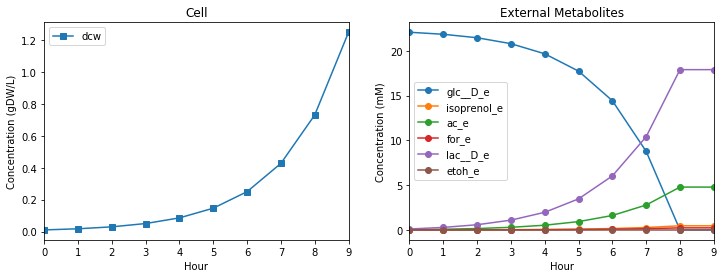

In [16]:
plot_DO_extmets(cell, Emets[['glc__D_e','isoprenol_e','ac_e','for_e','lac__D_e','etoh_e']])

We can see that some of the internal fluxes are maxed out the upper bound we established above:

In [17]:
for rxn in ['MDH','PTAr','CS','PPC']:
    print(str(rxn)+": "+ ', '.join([str(solution_TS[i].fluxes['CS']) for i in range(len(solution_TS))]))

MDH: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
PTAr: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
CS: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
PPC: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0


### Demo of function B: getting bioengineered flux profiles through MOMA

First obtain files with suggested designs (i.e. reactions kos and overexpressions):

In [18]:
design_df = pd.read_csv(f'{user_params["designfilepath"]}/{user_params["designfile"]}')

design_df = design_df.loc[0:9,:] # Truncate this data frame for faster testing!!!

In [19]:
design_df

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
0,1,1,1,2,0,2,0,0,0
1,2,1,2,2,2,2,1,1,0
2,3,1,0,0,2,1,1,2,0
3,4,1,1,1,1,2,2,1,0
4,5,2,0,2,1,1,0,1,1
5,6,2,0,0,1,2,0,1,0
6,7,2,1,2,2,2,2,0,2
7,8,1,1,0,1,2,0,0,0
8,9,2,1,2,2,0,0,0,2
9,10,2,2,2,0,1,0,2,0


Then use MOMA to calculate flux profiles at each time point for the bioengineered strains:

In [20]:
%%time
solutionsMOMA_TS = {}
for i in range(design_df.shape[0]):
    design = design_df.loc[i,:]
    solutionsMOMA_TS[i] = getBEFluxes(model_TS, design, solution_TS, grid)

CPU times: user 11min 44s, sys: 5.34 s, total: 11min 49s
Wall time: 11min 49s


We can check that the knocked out fluxes are zero:

In [21]:
i=0
print(str(design_df.loc[i,:])+'\n')
for rxn in ['CS','PPC','PFL']:
    print(str(rxn)+": "+str(solutionsMOMA_TS[i][5].fluxes[rxn]))

Line Name    1
ACCOAC       1
MDH          1
PTAr         2
CS           0
ACACT1r      2
PPC          0
PPCK         0
PFL          0
Name: 0, dtype: object

CS: 0.0
PPC: 0.0
PFL: 0.0


### Demo of function D: getting the external metabolite concentrations for each bioengineered strain

In [22]:
%%time
cellsEmetsBE = {}
for i in range(design_df.shape[0]):
    cell, Emets = integrate_fluxes(solutionsMOMA_TS[i], model_TS, user_params['ext_metabolites'], grid, BIOMASS_REACTION_ID)
    cellsEmetsBE[i] = (cell, Emets) 


CPU times: user 276 ms, sys: 0 ns, total: 276 ms
Wall time: 276 ms


We can check we obtain the same result with this function for the wild type as we did above:

In [23]:
cellWT, EmetsWT = integrate_fluxes(solution_TS, model_TS, user_params['ext_metabolites'], grid, BIOMASS_REACTION_ID)

In [24]:
EmetsWT

,glc__D_e,nh4_e,pi_e,so4_e,mg2_e,k_e,na1_e,cl_e,isoprenol_e,ac_e,for_e,lac__D_e,etoh_e
0.0,22.0707,18.6183,69.4472,1.99821,1.99994,21.8816,103.7,27.25,0.00264663,0.027405,0.00132331,0.102538,0
1.0,21.8444,18.4873,69.4354,1.99515,1.99983,21.8792,103.7,27.2499,0.00717176,0.0742613,0.00358588,0.277855,0
2.0,21.4576,18.2632,69.4154,1.98992,1.99965,21.8752,103.7,27.2498,0.0149087,0.154375,0.00745436,0.577608,0
3.0,20.7961,17.88,69.3812,1.98097,1.99935,21.8683,103.7,27.2496,0.0281372,0.291351,0.0140686,1.09012,0
4.0,19.6653,17.2248,69.3227,1.96567,1.99882,21.8564,103.7,27.2493,0.0507548,0.52555,0.0253774,1.96639,0
5.0,17.7317,16.1047,69.2227,1.93951,1.99792,21.8362,103.7,27.2488,0.0894259,0.925977,0.044713,3.46462,0
6.0,14.4258,14.1895,69.0516,1.89479,1.99638,21.8016,103.7,27.2478,0.155545,1.61062,0.0777724,6.02626,0
7.0,8.77335,10.915,68.7592,1.81833,1.99375,21.7424,103.7,27.2463,0.268593,2.7812,0.134297,10.4061,0
8.0,0,5.31631,68.2591,1.68759,1.98925,21.6412,103.7,27.2436,0.46188,4.78262,0.23094,17.8946,0
9.0,0,5.31631,68.2591,1.68759,1.98925,21.6412,103.7,27.2436,0.46188,4.78262,0.23094,17.8946,0


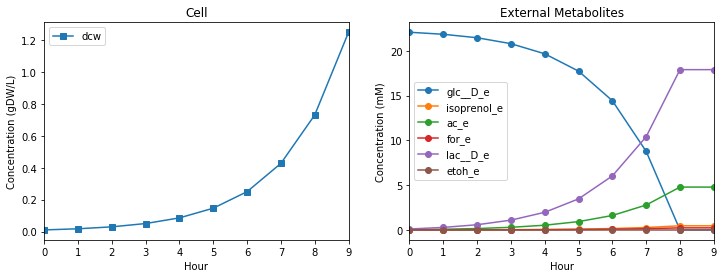

In [25]:
plot_DO_extmets(cellWT, EmetsWT[['glc__D_e','isoprenol_e','ac_e','for_e','lac__D_e','etoh_e']])

And compare with any other bioengineered strain:

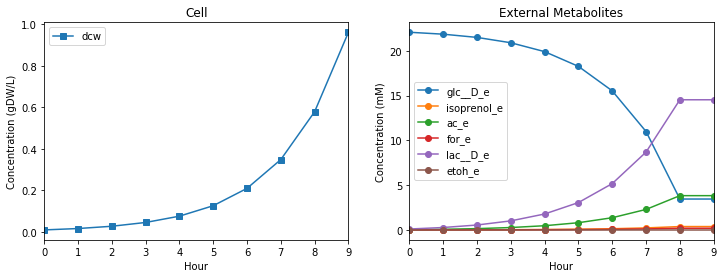

In [26]:
i = 2
cellBE, EmetsBE = cellsEmetsBE[i]
plot_DO_extmets(cellBE, EmetsBE[['glc__D_e','isoprenol_e','ac_e','for_e','lac__D_e','etoh_e']])

In [27]:
EmetsBE

,glc__D_e,nh4_e,pi_e,so4_e,mg2_e,k_e,na1_e,cl_e,isoprenol_e,ac_e,for_e,lac__D_e,etoh_e
0.0,22.0727,18.6195,69.4475,1.99824,1.99994,21.8817,103.7,27.25,0.0026061,0.0265712,0.0013026,0.100933,0
1.0,21.8564,18.4942,69.4368,1.99531,1.99985,21.8796,103.7,27.2499,0.0069344,0.0707016,0.003466,0.268566,0
2.0,21.4971,18.2861,69.419,1.99045,1.99969,21.876,103.7,27.2498,0.014123,0.143995,0.00705905,0.546977,0
3.0,20.9003,17.9404,69.3894,1.98238,1.99943,21.8701,103.7,27.2497,0.0260621,0.265723,0.0130265,1.00937,0
4.0,19.9093,17.3662,69.3403,1.96897,1.99899,21.8603,103.7,27.2494,0.0458909,0.467893,0.0229375,1.77733,0
5.0,18.2632,16.4126,69.2587,1.9467,1.99827,21.844,103.7,27.249,0.0788232,0.803664,0.039398,3.05279,0
6.0,15.5294,14.8289,69.1231,1.90972,1.99706,21.8169,103.7,27.2482,0.133518,1.36132,0.0667361,5.17111,0
7.0,10.989,12.1986,68.898,1.8483,1.99506,21.772,103.7,27.247,0.224358,2.28751,0.11214,8.68928,0
8.0,3.44811,7.83002,68.5241,1.74629,1.99175,21.6973,103.7,27.245,0.375228,3.82574,0.187549,14.5324,0
9.0,3.44811,7.83002,68.5241,1.74629,1.99175,21.6973,103.7,27.245,0.375228,3.82574,0.187549,14.5324,0


### Creating final data frame for training ART

Collect all isoprenol production values in a single list first:

In [28]:
production = []
for i in range(design_df.shape[0]):
    cell, Emets = cellsEmetsBE[i]
    production.append(Emets.loc[9,'isoprenol_e'])

Create new data frame and append the production

In [29]:
production_df = design_df

In [30]:
production_df['Production']=production

In [31]:
production_df.loc[0:2,:]

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Production
0,1,1,1,2,0,2,0,0,0,0.000000
1,2,1,2,2,2,2,1,1,0,0.453967
2,3,1,0,0,2,1,1,2,0,0.375228


Save data frame as csv:

In [32]:
production_df.to_csv('ART_training.csv')